In [3]:
import math
import numpy as np

from scipy import signal, ndimage
from PIL import Image, ImageDraw

# Part 1  #1
from ncc import normxcorr2D

## Part 1: Face Detection

#### 2.(5 points) MakeGaussianPyramid(image, scale, minsize)

RGB:


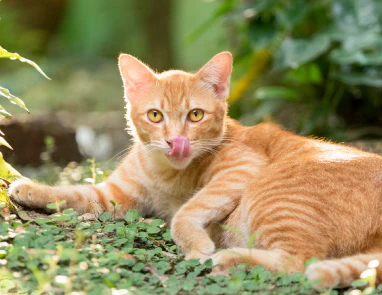

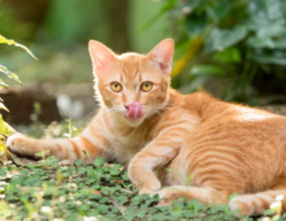

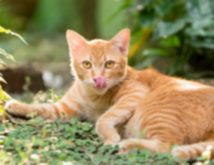

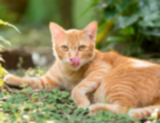

Grayscale:


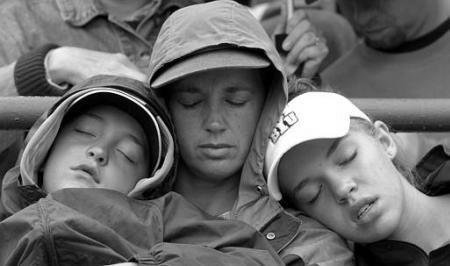

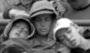

In [4]:
### Reference used: consulted ChatGPT for how to gaussian_filter RGB images
def applyGaussianFilter(image, scale):
    sigma = 1 / (2 * scale)
    if image.ndim == 3:  # RGB image
        return np.stack([
            ndimage.gaussian_filter(image[:, :, i], sigma)
            for i in range(image.shape[2])
        ], axis=-1)
    else:  # grayscale
        return ndimage.gaussian_filter(image, sigma)

def resizeImage(image, scale):
    height, width = image.shape[:2]
    scaled_h = int(height * scale)
    scaled_w = int(width * scale)
    # Resize and output as floating point nparray
    resized_image = np.array(
        Image.fromarray(image.astype(np.uint8)).resize((scaled_w, scaled_h), Image.BICUBIC)
    ).astype(np.float32)
    return resized_image

# pyramid as a list of 3d floating point nparray, not PIL img
def MakeGaussianPyramid(image, scale=0.75, minsize=150):
    pyramid = []
    # create pyramid till the minimum size is reached by the larger dimension:
    while max(image.shape[:2]) >= minsize:
        pyramid.append(image)
        image_filtered = applyGaussianFilter(image, scale)
        image_resized = resizeImage(image_filtered, scale)
        image = image_resized
    return pyramid

# Test on an RGB & a Grayscale img:
print("RGB:")
pyramid_RGB = MakeGaussianPyramid(np.asarray(Image.open('faces/orange_cat.jpeg')))
for img in pyramid_RGB:
    display(Image.fromarray(img.astype(np.uint8)))

print("Grayscale:")
pyramid_Gray = MakeGaussianPyramid(np.asarray(Image.open('faces/fans.jpg')), 0.2, 30)
for img in pyramid_Gray:
    display(Image.fromarray(img.astype(np.uint8)))

#### 3.(3 points)ShowGaussianPyramid(pyramid)

RGB:


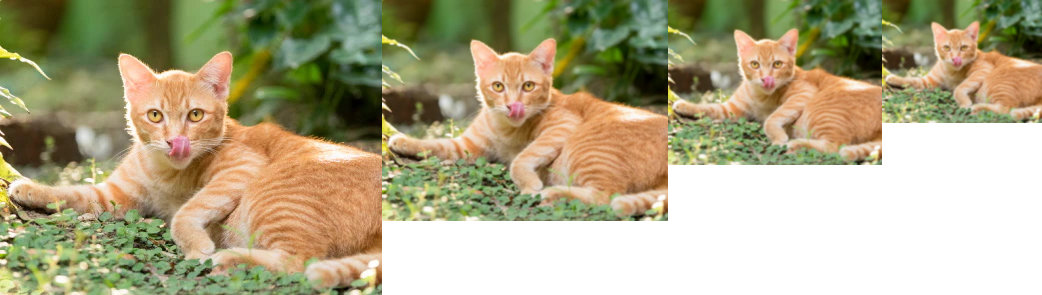

Grayscale:


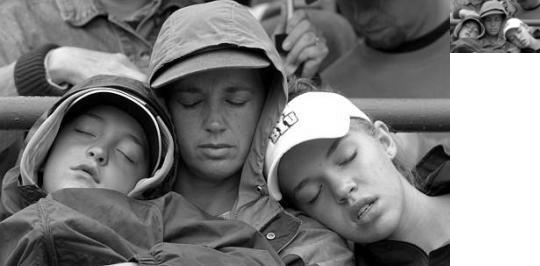

In [5]:
def ShowGaussianPyramid(pyramid):
    w = sum(img.shape[1] for img in pyramid)
    h = max(img.shape[0] for img in pyramid)
    ### Reference: https://www.geeksforgeeks.org/python-pil-image-new-method/
    # Use white as background color:
    isRGB = (pyramid[0].ndim == 3)
    # imgMode = "RGB" if isRGB else "L"
    # bgColor = (255, 255, 255) if isRGB else 255
    imgMode = "RGB"
    bgColor = (255, 255, 255)

    pyramid_img = Image.new(imgMode, (w, h), color=bgColor)
    # paste image horizontally:
    offset_x = 0
    for img in pyramid:
        img = Image.fromarray(img.astype(np.uint8))
        pyramid_img.paste(img, (offset_x, 0))
        offset_x += img.size[0]
    display(pyramid_img)

# Test on an RGB & a Grayscale pyramid:
print("RGB:")
ShowGaussianPyramid(pyramid_RGB)
print("Grayscale:")
ShowGaussianPyramid(pyramid_Gray)

#### 4.(12 points) `FindTemplate(pyramid, template, threshold)`

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


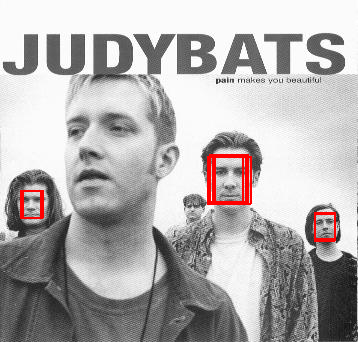

In [6]:
def FindTemplate(pyramid, template, threshold):
    # Reduce the template width to 15 pixels:
    resize_scale = 15 / template.shape[1]
    resized_template = Image.fromarray(resizeImage(template, resize_scale).astype(np.uint8))
    template_w, template_h = resized_template.size
    # display(resized_template)

    img_out = Image.fromarray(pyramid[0].astype(np.uint8)).convert('RGB')
    draw = ImageDraw.Draw(img_out)
    scale = round(pyramid[1].shape[1] / pyramid[0].shape[1], 2)
    # print(scale)

    for idx in range(len(pyramid)):
        # get cross_corr for each image (converted to grayscale to handle color images as well) in pyramid:
        im = Image.fromarray(pyramid[idx].astype(np.uint8)).convert("L")
        cross_corr = normxcorr2D(im, resized_template)
        # draw boxes if normalized correlation is above threshold:
        for i in range(cross_corr.shape[0]):
            for j in range(cross_corr.shape[1]):
                if cross_corr[i][j] > threshold:
                    scale_ratio = scale ** idx
                    # Get red box coordinates:
                    x1 = j / scale_ratio - template_w / (2 * scale_ratio)
                    y1 = i / scale_ratio - template_h / (2 * scale_ratio)
                    x2 = j / scale_ratio + template_w / (2 * scale_ratio)
                    y2 = i / scale_ratio + template_h / (2 * scale_ratio)
                    # Draw the red boxes on the original image:
                    draw.line((x1, y1, x2, y1), fill='red', width=2)
                    draw.line((x1, y1, x1, y2), fill='red', width=2)
                    draw.line((x2, y1, x2, y2), fill='red', width=2)
                    draw.line((x1, y2, x2, y2), fill='red', width=2)
    display(img_out)

# test
template = np.asarray(Image.open('faces/template.jpg'))
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/judybats.jpg'))), template, 0.7)


#### 5.(5 points)find a good threshold & calculate recall rate

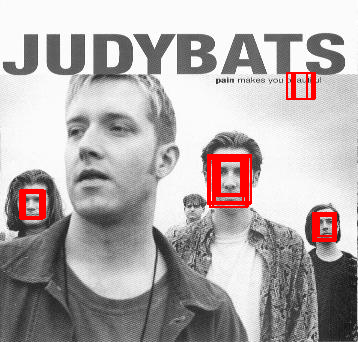

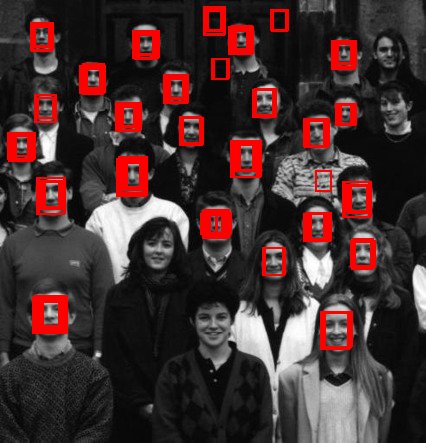

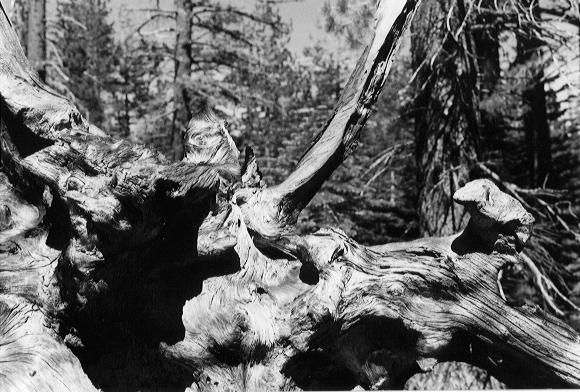

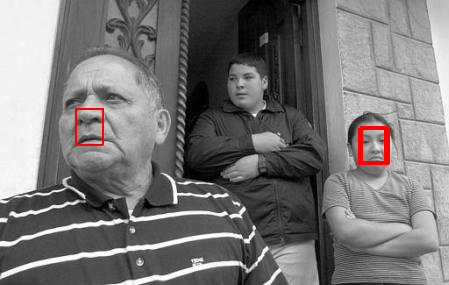

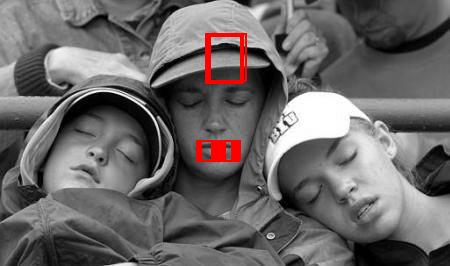

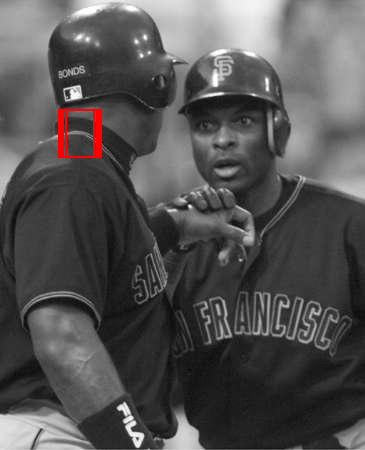

In [28]:
# An equal error rate is where the number of non-faces seen as faces (false positives) equals the number of missed faces (false negatives). This can be approxiamte, just count the number of non-faces that are detected by your program, and the number of missed faces.

# thresolds selected as in the 3rd parameter
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/judybats.jpg'))), template, 0.572)
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/students.jpg'))), template, 0.56)
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/tree.jpg'))), template, 0.65)
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/family.jpg'))), template, 0.569)
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/fans.jpg'))), template, 0.62)
FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/sports.jpg'))), template, 0.55)

# test on color image
# FindTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/orange_cat.jpeg'))), template, 0.5)

All the thresholds chosen below are aim to achieve an equal error rate, i.e., `False Postives` (number of non-faces seen as faces) `= False Negatives` (number of missed faces), and `Recall = True Positives / (True Positives + False Negatives)`, where `True Positives` means correct faces detected:
- For image `judybats`, threshold chosen is `0.572`, the recall rate is `recall = 3 / (3 + 2) = 0.6`.
- For image `students`, threshold chosen is `0.56`, the recall rate is `recall = 23 / (23 + 4) = 0.85`.
- For image `tree`, threshold chosen is `0.65`, the recall rate is `recall = 0 / (0 + 0) = 0/0` (no faces in this image case).
- For image `family`, threshold chosen is `0.569`, the recall rate is `recall = 1 / (1 + 2) = 0.33`.
- For image `fans`, threshold chosen is `0.62`, the recall rate is `recall = 0 / (0 + 3) = 0`.
- For image `sports`, threshold chosen is `0.55`, the recall rate is `recall = 0 / (0 + 1) = 0`.

## Part 2: Image Blending

#### 2.(3 points) MakeLaplacianPyramid(image, scale, minsize)

In [52]:
def MakeLaplacianPyramid(image, scale=0.75, minsize=150):
    laplacian_pyramid = []
    gaussian_pyramid = MakeGaussianPyramid(image, scale, minsize)
    # subtract each current-level img with its blurred ver. (except last one):
    for i in range(len(gaussian_pyramid) - 1):
        curr_img= gaussian_pyramid[i]
        blurred_curr_img = applyGaussianFilter(curr_img, scale)
        laplacian_curr = curr_img - blurred_curr_img
        laplacian_pyramid.append(laplacian_curr)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

# # Test on an RGB & a Grayscale img:
# print("RGB:")
# laplacian_pyramid_RGB = MakeLaplacianPyramid(np.asarray(Image.open('hw2part2/orchid.jpg')))
# for img in laplacian_pyramid_RGB:
#     display(Image.fromarray(img.astype(np.uint8)))

# print("Grayscale:")
# laplacian_pyramid_Gray = MakeLaplacianPyramid(np.asarray(Image.open('faces/fans.jpg')), 0.2, 30)
# for img in laplacian_pyramid_Gray:
#     display(Image.fromarray(img.astype(np.uint8)))

#### 3.(2 points) ShowLaplacianPyramid(pyramid)

Orchid:


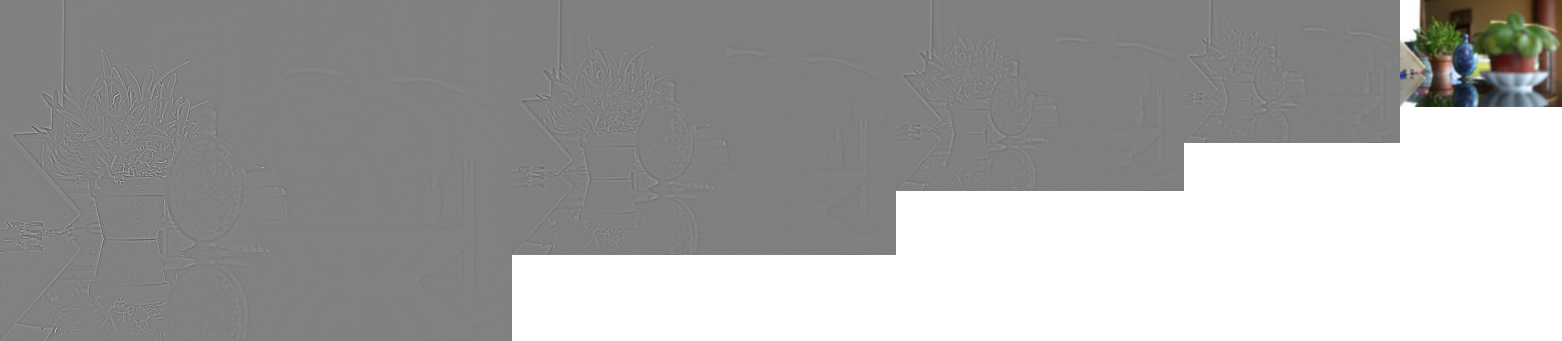

Violet:


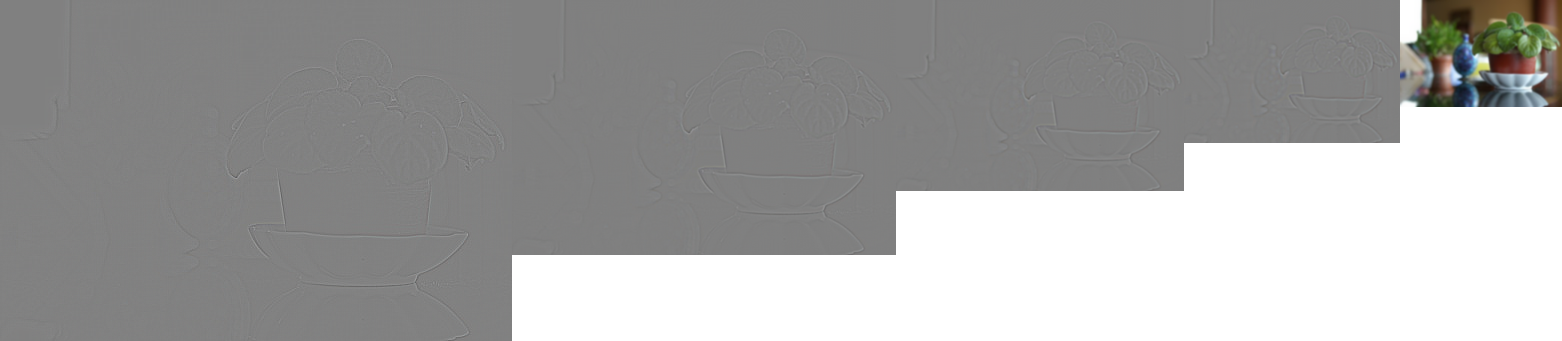

In [63]:
def ShowLaplacianPyramid(pyramid):
    w = sum(img.shape[1] for img in pyramid)
    h = max(img.shape[0] for img in pyramid)
    # Use white as background color:
    isRGB = (pyramid[0].ndim == 3)
    imgMode = "RGB"
    bgColor = (255, 255, 255)

    pyramid_img = Image.new(imgMode, (w, h), color=bgColor)
    # paste image horizontally:
    offset_x = 0
    for i in range(len(pyramid) - 1):
        # to visualize/create gray background:
        img = np.clip(pyramid[i]+128, 0, 255)
        img = Image.fromarray(img.astype(np.uint8))
        pyramid_img.paste(img, (offset_x, 0))
        offset_x += img.size[0]
    pyramid_img.paste(Image.fromarray(pyramid[-1].astype(np.uint8)), (offset_x, 0))
    display(pyramid_img)

# Test orchid and violet laplacian pyramids:
print("Orchid:")
laplacian_pyramid_1 = MakeLaplacianPyramid(np.asarray(Image.open('hw2part2/orchid.jpg')))
ShowLaplacianPyramid(laplacian_pyramid_1)
print("Violet:")
laplacian_pyramid_2 = MakeLaplacianPyramid(np.asarray(Image.open('hw2part2/violet.jpg')))
ShowLaplacianPyramid(laplacian_pyramid_2)

#### 4.(5 points) ReconstructGaussianFromLaplacianPyramid(lPyramid)

Reconstructed Gaussian Pyramid (RGB):


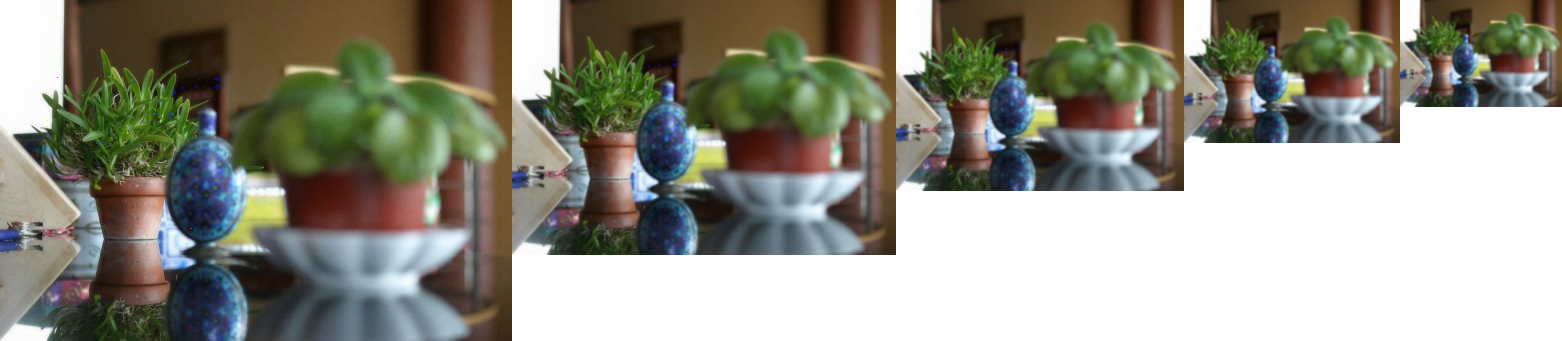

In [105]:
# return pyramid as a list of 3d floating point nparray, not PIL img
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
    reconstruct_gaussian_pyramid = []
    # append the last/highest-level Laplacian img:
    reconstruct_gaussian_pyramid.append(lPyramid[-1].astype(np.float32))
    # upsample and add up ecursively
    for i in range(len(lPyramid) - 2, -1, -1):
        upsampled_img = Image.fromarray(np.uint8(reconstruct_gaussian_pyramid[0])).resize((lPyramid[i].shape[1], lPyramid[i].shape[0]), Image.BICUBIC)
        upsampled_img = np.array(upsampled_img, dtype=np.float32)
        curr_reconstruct_img = upsampled_img + lPyramid[i]
        # insert the reconstructed Gaussian level at the front:
        reconstruct_gaussian_pyramid.insert(0, curr_reconstruct_img)
    return reconstruct_gaussian_pyramid

# Test on an RGB & a Grayscale Laplacian pyramids:
print("Reconstructed Gaussian Pyramid (RGB):")
laplacian_pyramid_RGB = MakeLaplacianPyramid(np.asarray(Image.open('hw2part2/orchid.jpg')))
gaussian_pyramid_RGB = ReconstructGaussianFromLaplacianPyramid(laplacian_pyramid_RGB)
ShowGaussianPyramid(gaussian_pyramid_RGB)



#### 5.(2 points) construct and visualize a Gaussian pyramid of the orchid_mask.bmp image

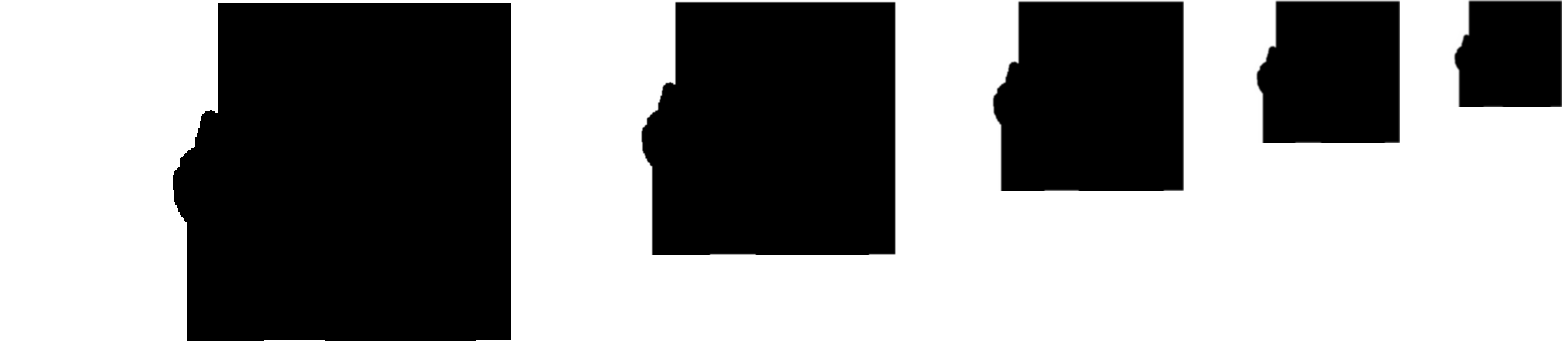

In [106]:
orchid_mask_gaussian_pyramid = MakeGaussianPyramid(np.asarray(Image.open('hw2part2/orchid_mask.bmp')))
ShowGaussianPyramid(orchid_mask_gaussian_pyramid)

#### 6.(5 points)

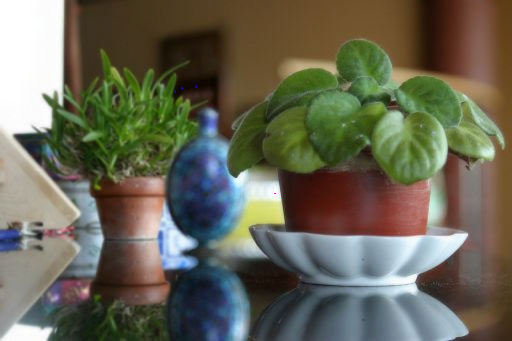

In [119]:
def BlendLaplacianPyramids(lPyramidA, lPyramidB, gaussianPyramidMask):
    blended_laplacian_pyramid = []
    gaussianM = [] # for 3D mask
    for gpm in gaussianPyramidMask:
        # Reference: https://stackoverflow.com/questions/32171917/how-to-copy-a-2d-array-into-a-3rd-dimension-n-times
        gpm = np.repeat(gpm[:, :, np.newaxis], 3, axis=2)
        gaussianM.append(gpm)
    # iterate through each level of the Laplacian pyramids and blend
    for i in range(len(lPyramidA)):
        lapA = lPyramidA[i]
        lapB = lPyramidB[i]
        # Perform blending for each channel (assuming RGB images)
        blended_l = lapA * gaussianM[i]/255 + lapB * (1 - gaussianM[i]/255)
        blended_laplacian_pyramid.append(blended_l)
    return blended_laplacian_pyramid



# for display the highest resolution level of blended image:
def displayBlendedHighRes(img1_path, img2_path, mask_path):
    # Test on blending blue_cup and green_cup
    img_1 = np.asarray(Image.open(img1_path))
    img_2 = np.asarray(Image.open(img2_path))
    mask = np.asarray(Image.open(mask_path))
    # Create pyramids:
    lapA = MakeLaplacianPyramid(img_1)
    lapB = MakeLaplacianPyramid(img_2)
    mask_gaussian_pyramid = MakeGaussianPyramid(mask)
    # Blend:
    blended_laplacian_pyramid = BlendLaplacianPyramids(lapA, lapB, mask_gaussian_pyramid)
    reconstructed_gaussian_pyramid = ReconstructGaussianFromLaplacianPyramid(blended_laplacian_pyramid)
    # ShowGaussianPyramid(reconstructed_gaussian_pyramid)
    # display the highest resolution level of blended image:
    high_res_img = Image.fromarray(reconstructed_gaussian_pyramid[0].astype(np.uint8))
    display(high_res_img)

# show blend of orchid and violet:
displayBlendedHighRes('hw2part2/orchid.jpg', 'hw2part2/violet.jpg', 'hw2part2/orchid_mask.bmp')


#### 7.(3 points) Experiment with additional pairs

blend green cup with blue cup: 


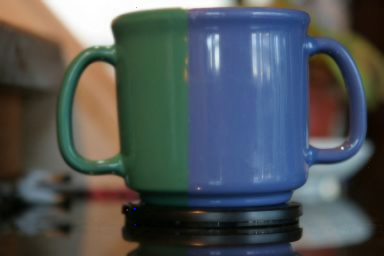

blend tomato and apple: 


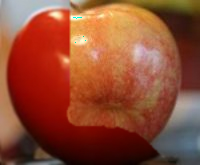

In [126]:
# Test on blending blue_cup and green_cup
print("blend green cup with blue cup: ")
displayBlendedHighRes('hw2part2/green_cup.jpg', 'hw2part2/blue_cup.jpg', 'hw2part2/cup_mask.bmp')

# Test on blending tomato and apple:
print("blend tomato and apple: ")
displayBlendedHighRes('hw2part2/tomato.jpg', 'hw2part2/apple.jpg', 'hw2part2/tomato_mask.bmp')
